<a href="https://colab.research.google.com/github/bchou9/eec289Ahw/blob/main/EEC_289A_HW2_Manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Non-Parametric Sampling for Texture Synthesis
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st #for gaussian kernel
import cv2


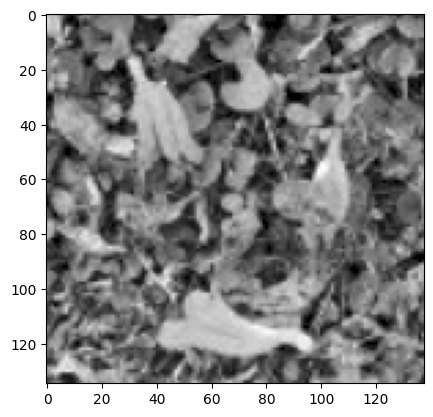

(135, 138)

In [ ]:
# Read in Image
img_array = cv2.imread("8reduced.png", cv2.IMREAD_GRAYSCALE)
img_array = img_array / np.max(img_array)
plt.imshow(img_array,cmap='gray')
plt.show()
img_array.shape

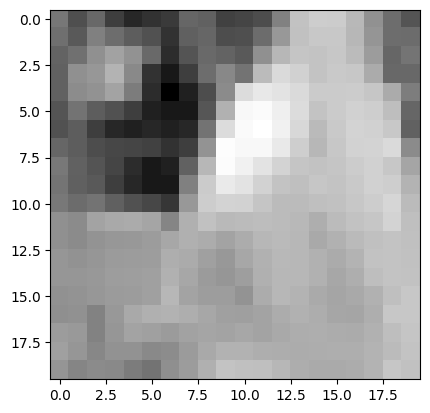

(20, 20)

In [ ]:
def getNeighborhoodWindow(img, pixel, windowsize):

  cen_x = pixel[0]
  cen_y = pixel[1]

  # Calculate the start and end indices for slicing
  start_x = cen_x - windowsize // 2
  end_x = start_x + windowsize
  start_y = cen_y - windowsize // 2
  end_y = start_y + windowsize

  # Ensure the indices are within the bounds of the array
  start_x = max(0, start_x)
  end_x = min(img.shape[0], end_x)
  start_y = max(0, start_y)
  end_y = min(img.shape[1], end_y)

  # Extract the subarray using slicing
  neighborhood = img[start_x:end_x, start_y:end_y]

  return neighborhood

pix = (60,100)
win_size = 20

sub_img = getNeighborhoodWindow(img_array,pix,win_size)
plt.imshow(sub_img,cmap='gray')
plt.show()
sub_img.shape

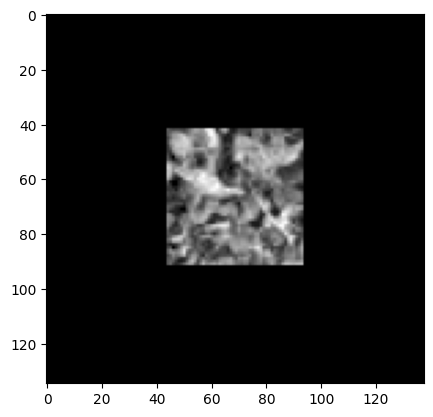

In [ ]:
def image_seed(targ_image, seed_size,canvas_shape):


  shape_x, shape_y = targ_image.shape
  allowable_x_high = shape_x - seed_size
  allowable_y_high = shape_y - seed_size

  canvas = np.zeros((canvas_shape))

  start_x = np.random.randint(0, allowable_x_high)
  start_y = np.random.randint(0, allowable_y_high)

  # Calculate the start and end indices for slicing
  end_x = start_x + seed_size
  end_y = start_y + seed_size

  # Ensure the indices are within the bounds of the array
  start_x = max(0, start_x)
  end_x = min(targ_image.shape[0], end_x)
  start_y = max(0, start_y)
  end_y = min(targ_image.shape[1], end_y)

  smaller_array = targ_image[start_x:end_x, start_y:end_y]

  # Determine the center coordinates of the smaller array
  smaller_shape = smaller_array.shape
  center_row = canvas.shape[0] // 2 - smaller_shape[0] // 2
  center_col = canvas.shape[1] // 2 - smaller_shape[1] // 2

  # Assign values from the smaller array to the center of the larger array
  canvas[center_row:center_row + smaller_shape[0], center_col:center_col + smaller_shape[1]] = smaller_array



  return canvas




canv = image_seed(img_array, 50, img_array.shape)
plt.imshow(canv,cmap='gray')
plt.show()

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
unfilled = canv - img_array
from scipy.ndimage import binary_dilation

def GetUnfilledNeighbors(image, unfilled_value):
    # Create a binary mask where unfilled pixels are True
    unfilled_mask = (image == unfilled_value)

    # Compute the morphological dilation of the mask
    struct = np.ones((3, 3), dtype=bool)
    dilation = binary_dilation(input=unfilled_mask, structure=struct)

    # Subtract the original mask from its dilation to get unfilled neighbors
    unfilled_neighbors = dilation & ~unfilled_mask

    # Get the coordinates of unfilled pixels
    unfilled_coords = np.transpose(np.nonzero(unfilled_neighbors))

    # Get the number of filled neighbors for each unfilled pixel
    filled_neighbors_count = []
    for coord in unfilled_coords:
        row, col = coord
        neighborhood = dilation[row-1:row+2, col-1:col+2]  # 8-neighborhood
        filled_neighbors_count.append(np.sum(neighborhood) - 1)  # Exclude the central pixel

    # Combine coordinates and filled neighbor counts
    unfilled_info = list(zip(unfilled_coords, filled_neighbors_count))

    # Randomly permute the list
    np.random.shuffle(unfilled_info)

    # Sort by decreasing number of filled neighbor pixels
    unfilled_info.sort(key=lambda x: x[1], reverse=True)

    # Return the sorted list of unfilled neighbors
    return [info[0] for info in unfilled_info]


unfilled_neighbors = GetUnfilledNeighbors(canv, 0)
print("Unfilled neighbors:")
print(unfilled_neighbors)
canv[92,70]

Unfilled neighbors:
[array([52, 45]), array([61, 44]), array([62, 44]), array([52, 44]), array([61, 45]), array([85, 44]), array([62, 45]), array([85, 45]), array([51, 44]), array([63, 44]), array([53, 44]), array([42, 93]), array([86, 44]), array([84, 44]), array([91, 93]), array([91, 44]), array([60, 44]), array([42, 44]), array([63, 45]), array([51, 45]), array([90, 44]), array([43, 93]), array([83, 44]), array([42, 45]), array([53, 45]), array([84, 45]), array([42, 92]), array([86, 45]), array([64, 44]), array([91, 45]), array([43, 44]), array([91, 92]), array([59, 44]), array([54, 44]), array([60, 45]), array([50, 44]), array([90, 93]), array([87, 44]), array([42, 74]), array([66, 44]), array([47, 93]), array([56, 68]), array([56, 66]), array([42, 68]), array([67, 44]), array([52, 93]), array([42, 65]), array([73, 44]), array([91, 82]), array([42, 86]), array([48, 93]), array([58, 93]), array([85, 93]), array([42, 84]), array([86, 46]), array([42, 57]), array([91, 67]), array([42,

0.0

In [ ]:
from scipy.ndimage import gaussian_filter

def FindMatches(Template, SampleImage, WindowSize, Sigma, ErrThreshold):
    # Create valid mask where Template is filled
    ValidMask = (Template != 0).astype(float)

    # Create Gaussian mask
    GaussMask = gaussian_filter(np.ones_like(Template), sigma=Sigma)

    # Compute total weight
    TotWeight = np.sum(GaussMask * ValidMask)

    # Initialize SSD matrix
    SSD = np.zeros_like(SampleImage, dtype=float)

    # Compute SSD for each pixel
    for i in range(WindowSize, SampleImage.shape[0]):
        for j in range(WindowSize, SampleImage.shape[1]):
            for ii in range(WindowSize):
                for jj in range(WindowSize):
                    dist = (Template[ii, jj] - SampleImage[i-ii, j-jj]) ** 2
                    SSD[i, j] += dist * ValidMask[ii, jj] * GaussMask[ii, jj]
            SSD[i, j] /= TotWeight

    # Find pixels with SSD <= min(SSD) * (1 + ErrThreshold)
    min_SSD = np.min(SSD)
    threshold = min_SSD * (1 + ErrThreshold)
    PixelList = np.argwhere(SSD <= threshold)

    return PixelList

WindowSize = 3
Sigma = 1.0
ErrThreshold = 0.1
pixel_list = FindMatches(canv, img_array, WindowSize, Sigma, ErrThreshold)


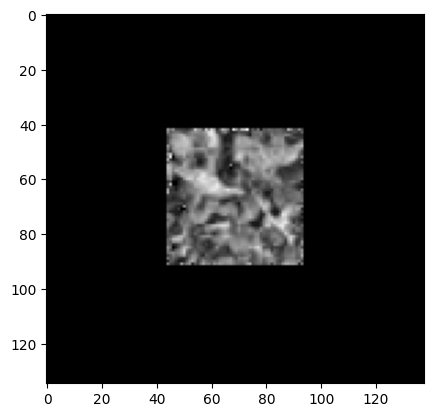

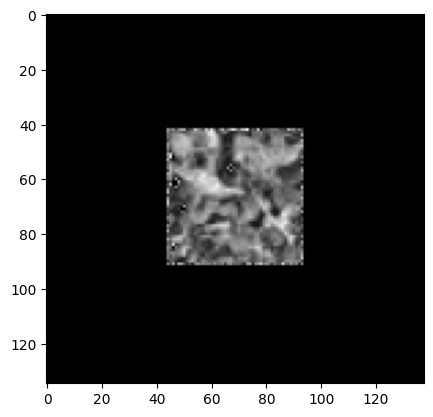

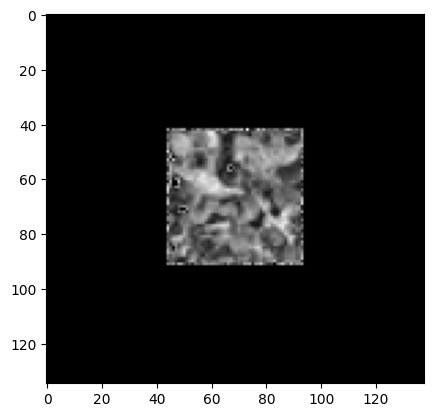

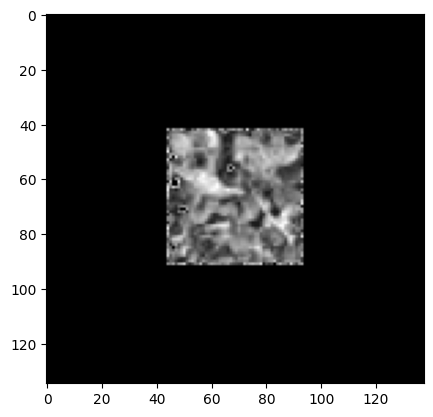

In [ ]:
# Define the function to grow the image
import random

# Define the function to grow the image
def GrowImage(SampleImage, Image, WindowSize, unfilled_value, Sigma, ErrThreshold):
    # Set initial parameters
    MaxErrThreshold = 0.1

    # Main loop until Image is filled
    while not np.all(Image):
        progress = 0
        prog = 0
        PixelList = GetUnfilledNeighbors(Image, unfilled_value)
        for Pixel in PixelList:
            # Get neighborhood window
            row, col = Pixel
            Template = SampleImage[row:row+WindowSize, col:col+WindowSize]

            # Find best matches
            BestMatches = FindMatches(Image, SampleImage, WindowSize, Sigma, ErrThreshold)

            # Randomly pick a best match
            if BestMatches.any():
                BestMatch = random.choice(BestMatches)
                Image[row, col] = SampleImage[BestMatch[0], BestMatch[1]]
                progress = 1
            prog += 1

            if prog == 100:
              plt.imshow(Image,cmap='gray')
              plt.show()
              prog = 0
        # If no progress, increase the error threshold
        if progress == 0:
            MaxErrThreshold *= 1.1

        # If no progress, increase the error threshold
        if progress == 0:
            MaxErrThreshold *= 1.1

    return Image
WindowSize = 23
Sigma = 1.0
ErrThreshold = 0.1
unfilled_value = 0

# Call the GrowImage function
result_image = GrowImage(img_array, canv, WindowSize, unfilled_value, Sigma, ErrThreshold,)